In [4]:
#import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import blink
from pathlib import Path
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr


In [5]:
#functions
import blink

def bandpass_filter(data, fs, lowcut, highcut, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def lowpass_filter(data, fs, cutoff, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def remove_close_blinks_keep_median(blink_times, blink_values, min_interval_ms):
    if len(blink_times) == 0:
        return blink_times, blink_values
    idx_sort = np.argsort(blink_times)
    times = np.array(blink_times)[idx_sort]
    values = np.array(blink_values)[idx_sort]
    keep_idx = []
    group = [0]
    for i in range(1, len(times)):
        if (times[i] - times[i-1]) * 1000 < min_interval_ms:
            group.append(i)
        else:
            median_i = group[len(group)//2]
            keep_idx.append(median_i)
            group = [i]
    if group:
        median_i = group[len(group)//2]
        keep_idx.append(median_i)
    keep_idx = np.array(keep_idx)
    return times[keep_idx], values[keep_idx]

def extract_segments(psychopy_path):
    psychopy_df = pd.read_csv(psychopy_path, sep=";", header=None, names=["label", "time"])
    segments = {}
    current_segment = None
    for _, row in psychopy_df.iterrows():
        if pd.isna(row["label"]) or row["label"].strip() == "":
            continue
        label = row["label"].strip()
        time = row["time"]
        if label.lower().endswith("_start"):
            current_segment = label[:-6]
            segments[current_segment] = {"start": time, "end": None}
        elif label.lower().endswith("_end"):
            current_segment = label[:-4]
            if current_segment in segments:
                segments[current_segment]["end"] = time
    segments = {k: v for k, v in segments.items() if v["start"] is not None and v["end"] is not None}
    return segments

def analyze_blinks_and_save(
    base_lsl, base_tobii, excel_out_path,
    participant, task, openness_thresh,
    partial_percentage=0.8, eye='right'
):
    base_lsl = Path(base_lsl)
    base_tobii = Path(base_tobii)
    excel_out_path = Path(excel_out_path)

    # --- Determine task for file naming ---
    if task in ["Run", "Run_frame_fixed", "Walk"]:
        psychopy_task = "treadmill"
    else:
        psychopy_task = task.lower()

    # --- Segment extraction ---
    psychopy_path = base_lsl / participant / f"{participant}_{psychopy_task}_psychopy.csv"
    segments = extract_segments(psychopy_path)
    start_time, end_time = segments[task]["start"], segments[task]["end"]

    # --- EOG Data ---
    eog_file = base_lsl / participant / f"{participant}_{psychopy_task}_EOG.csv"
    df_eog = pd.read_csv(eog_file, sep=";", names=["EOG", "time"])
    df_eog_segment = df_eog[(df_eog["time"] >= start_time) & (df_eog["time"] <= end_time)]
    eog_signal = df_eog_segment["EOG"].to_numpy()
    eog_time = np.arange(len(eog_signal)) / 1000

    # --- Tobii Data ---
    tobii_file = base_tobii / participant / f"{participant}_{task}.tsv"
    df_tobii = pd.read_csv(tobii_file, sep="\t")
    eye_openness_signal = df_tobii[f"{eye}_eye_openness_diameter"].to_numpy()
    eye_time = np.arange(len(eye_openness_signal)) / 1200

    # --- Blink Detection by Tobii (blink.py) ---
    settings = blink.Settings()
    settings.Fs = 1200
    bd = blink.BlinkDetector(settings)
    df_eo, _ = bd.blink_detector_eo(
        eye_time, eye_openness_signal, settings.Fs,
        filter_length=settings.filter_length,
        gap_dur=settings.gap_dur,
        width_of_blink=settings.width_of_blink,
        min_separation=settings.min_separation
    )
    blink_peak_time_openness = df_eo["time_peak"].to_numpy()
    # Find corresponding index in the signal
    peak_idx = np.searchsorted(eye_time, blink_peak_time_openness)

    # --- Filtering ---
    eog_signal_filt = lowpass_filter(eog_signal, fs=1000, cutoff=5)
    eye_openness_signal_filt = lowpass_filter(eye_openness_signal, fs=1200, cutoff=5)

    # --- Parameters for blink detection ---
    max_blink_amplitude_openness = openness_thresh
    min_blink_width_ms_openness = 1
    max_blink_width_ms_openness = 1500
    prominence_openness = 0.5
    min_blink_amplitude_eog = 0.15
    min_blink_width_ms_eog = 5
    max_blink_width_ms_eog = 2000
    prominence_eog = 0.001
    min_interval = 1500
    EOG_POLARITY = 'negative'

    width_samples_openness = int(np.round(min_blink_width_ms_openness / 1000 * 1200))
    openness_thresh_val = max_blink_amplitude_openness
    min_width_samples_eog = int(np.round(min_blink_width_ms_eog / 1000 * 1000))
    max_width_samples_eog = int(np.round(max_blink_width_ms_eog / 1000 * 1000))

    # ---- Find blinks in filtered Eye Openness ----
    peaks_openness, props_open = find_peaks(
        -eye_openness_signal_filt,
        height=-openness_thresh_val,
        distance=width_samples_openness,
        width=(min_blink_width_ms_openness, max_blink_width_ms_openness),
        prominence=prominence_openness
    )
    blink_peak_time_openness = eye_time[peaks_openness]
    blink_peaks_y_openness = eye_openness_signal_filt[peaks_openness]

    # ---- Find blinks in filtered EOG ----
    if EOG_POLARITY == 'negative':
        eog_for_peaks = -eog_signal_filt
        height_eog = abs(min_blink_amplitude_eog)
    else:
        eog_for_peaks = eog_signal_filt
        height_eog = min_blink_amplitude_eog

    peaks_eog, props_eog = find_peaks(
        eog_for_peaks,
        height=height_eog,
        distance=min_width_samples_eog,
        width=(min_width_samples_eog, max_width_samples_eog),
        prominence=prominence_eog
    )
    blink_peaks_time_eog = eog_time[peaks_eog]
    blink_peaks_y_eog = eog_signal_filt[peaks_eog]

    # ---- Remove closely spaced blinks (median) ----
    blink_peak_time_openness, blink_peaks_y_openness = remove_close_blinks_keep_median(
        blink_peak_time_openness, blink_peaks_y_openness, min_interval_ms=min_interval
    )
    blink_peaks_time_eog, blink_peaks_y_eog = remove_close_blinks_keep_median(
        blink_peaks_time_eog, blink_peaks_y_eog, min_interval_ms=min_interval
    )

    # ---- Calculate segment duration for blink rate ----
    segment_duration_min = (end_time - start_time) / 60.0

    # ---- Calculate blink rates ----
    eog_blink_rate = len(blink_peaks_time_eog) / segment_duration_min if segment_duration_min > 0 else np.nan
    tobii_blink_rate = len(blink_peak_time_openness) / segment_duration_min if segment_duration_min > 0 else np.nan

    # --- PBR detection using the 5th largest amplitude for Tobii ---
    sorted_peaks = np.sort(blink_peaks_y_openness)
    if len(sorted_peaks) >= 5:
        fifth_min = sorted_peaks[4]
    else:
        fifth_min = sorted_peaks[-1]
    partial_threshold_openness = (1 - partial_percentage) * fifth_min

    # --- EOG: threshold by percentage of max absolute amplitude ---
    if EOG_POLARITY == 'negative':
        partial_threshold_eog = -partial_percentage * np.max(np.abs(blink_peaks_y_eog))
    else:
        partial_threshold_eog = partial_percentage * np.max(np.abs(blink_peaks_y_eog))

    # --- Find indices of partial blinks
    incomplete_idx_openness = np.where(blink_peaks_y_openness > partial_threshold_openness)[0]
    complete_idx_openness = np.where(blink_peaks_y_openness <= partial_threshold_openness)[0]
    if EOG_POLARITY == 'negative':
        incomplete_idx_eog = np.where(blink_peaks_y_eog > partial_threshold_eog)[0]
        complete_idx_eog = np.where(blink_peaks_y_eog <= partial_threshold_eog)[0]
    else:
        incomplete_idx_eog = np.where(blink_peaks_y_eog < partial_threshold_eog)[0]
        complete_idx_eog = np.where(blink_peaks_y_eog >= partial_threshold_eog)[0]

    # --- Partial Blink Rates ---
    partial_blink_rate_openness = np.sum(blink_peaks_y_openness > partial_threshold_openness) / len(blink_peaks_y_openness) if len(blink_peaks_y_openness) > 0 else np.nan
    if EOG_POLARITY == 'negative':
        partial_blink_rate_eog = np.sum(blink_peaks_y_eog > partial_threshold_eog) / len(blink_peaks_y_eog) if len(blink_peaks_y_eog) > 0 else np.nan
    else:
        partial_blink_rate_eog = np.sum(blink_peaks_y_eog < partial_threshold_eog) / len(blink_peaks_y_eog) if len(blink_peaks_y_eog) > 0 else np.nan

    # === Plots ===
    # 1. Eye Openness (Tobii)
    plt.figure(figsize=(10, 3))
    plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
    plt.plot(blink_peak_time_openness[complete_idx_openness], blink_peaks_y_openness[complete_idx_openness], "kx", ms=10, lw=2, label="Complete Blinks")
    plt.plot(blink_peak_time_openness[incomplete_idx_openness], blink_peaks_y_openness[incomplete_idx_openness], "o", ms=10, color="red", label="Partial Blinks")
    plt.axhline(y=openness_thresh_val, color="green", linestyle="--", label="Openness Threshold")
    plt.axhline(y=partial_threshold_openness, color="magenta", linestyle=":", label=f"Partial Blink Threshold (5th deepest ×{int((1-partial_percentage)*100)}%)")
    plt.xlabel("Time (s)")
    plt.title(f"{participant} {task} - Filtered Eye Openness & Detected Blinks")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. EOG
    plt.figure(figsize=(10, 3))
    plt.plot(eog_time, eog_signal_filt, label="Filtered EOG", color="tab:blue")
    plt.plot(blink_peaks_time_eog[complete_idx_eog], blink_peaks_y_eog[complete_idx_eog], "rx", ms=10, lw=2, label="Complete Blinks")
    plt.plot(blink_peaks_time_eog[incomplete_idx_eog], blink_peaks_y_eog[incomplete_idx_eog], "o", ms=10, color="red", label="Partial Blinks")
    plt.axhline(y=-abs(min_blink_amplitude_eog), color="purple", linestyle="--", label="EOG Threshold")
    plt.axhline(y=partial_threshold_eog, color="magenta", linestyle=":", label=f"Partial Blink Threshold ({int(partial_percentage*100)}% max)")
    plt.xlabel("Time (s)")
    plt.title(f"{participant} {task} - Filtered EOG & Detected Blinks")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 3. Both signals together
    plt.figure(figsize=(10, 3))
    plt.plot(eog_time, eog_signal_filt * 10, label="Filtered EOG ×10", color="tab:blue")
    plt.plot(eye_time, eye_openness_signal_filt, label="Filtered Eye Openness", color="orange")
    plt.plot(blink_peak_time_openness[complete_idx_openness], blink_peaks_y_openness[complete_idx_openness], "kx", ms=10, lw=2, label="Blinks (openness)")
    plt.plot(blink_peak_time_openness[incomplete_idx_openness], blink_peaks_y_openness[incomplete_idx_openness], "o", ms=10, color="red", label="Partial Blinks (openness)")
    plt.plot(blink_peaks_time_eog[complete_idx_eog], blink_peaks_y_eog[complete_idx_eog] * 10, "rx", ms=10, lw=2, label="Blinks (EOG)")
    plt.plot(blink_peaks_time_eog[incomplete_idx_eog], blink_peaks_y_eog[incomplete_idx_eog] * 10, "o", ms=10, color="lime", label="Partial Blinks (EOG)")
    plt.axhline(y=openness_thresh_val, color="green", linestyle="--", label="Openness Threshold")
    plt.axhline(y=partial_threshold_openness, color="magenta", linestyle=":", label=f"Partial Blink Threshold Openness (5th deepest ×{int((1-partial_percentage)*100)}%)")
    plt.axhline(y=-abs(min_blink_amplitude_eog) * 10, color="purple", linestyle="--", label="EOG Threshold")
    plt.axhline(y=partial_threshold_eog * 10, color="cyan", linestyle=":", label=f"Partial Blink Threshold EOG ({int(partial_percentage*100)}% max)")
    plt.xlabel("Time (s)")
    plt.title(f"{participant} {task} - Both Filtered Signals & Blinks")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === Save result to Excel ===
    task_id = f"{participant}_{task}"
    main_row = {
        "Task_ID": task_id,
        "Blink Rate (EOG)": eog_blink_rate,
        "Blink Rate (Tobii)": tobii_blink_rate,
        "Partial Blink Rate (EOG)": partial_blink_rate_eog,
        "Partial Blink Rate (Tobii)": partial_blink_rate_openness,
    }
    if excel_out_path.exists():
        df = pd.read_excel(excel_out_path)
        df = df[df["Task_ID"] != task_id]  # Remove old entry for this participant & task
        df = pd.concat([df, pd.DataFrame([main_row])], ignore_index=True)
    else:
        df = pd.DataFrame([main_row])
    df.to_excel(excel_out_path, index=False)
    print(f"Summary saved to: {excel_out_path}")

    return {
        "Partial Blink Rate (EOG)": partial_blink_rate_eog,
        "Partial Blink Rate (Tobii)": partial_blink_rate_openness
    }



Processing 01_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


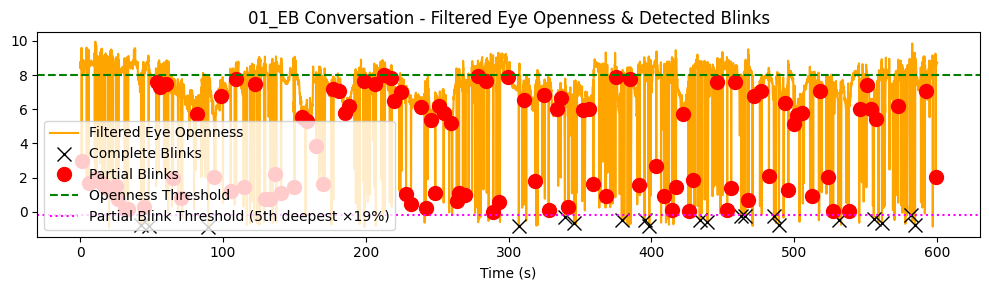

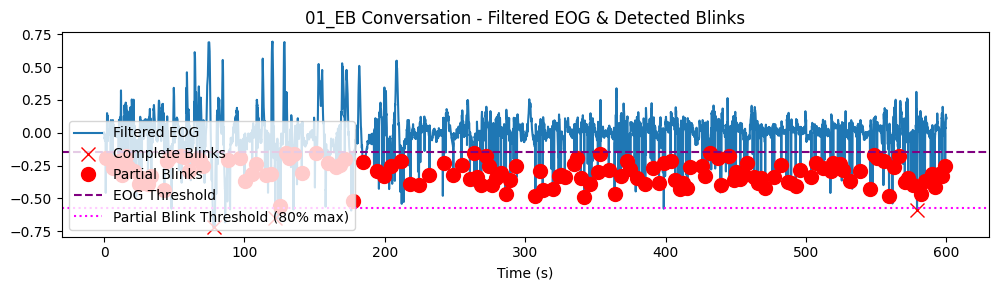

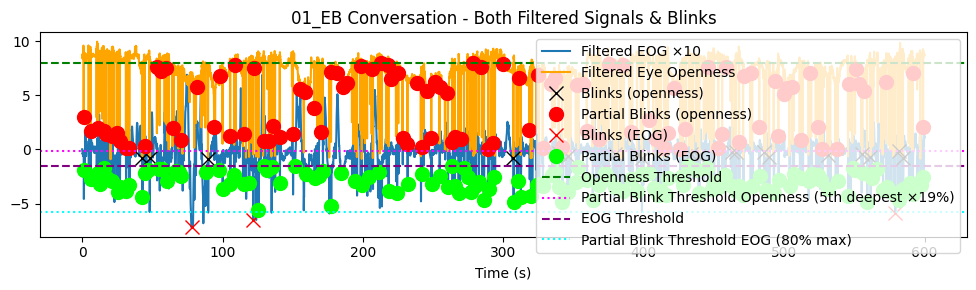

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.979 | PBR (Tobii): 0.840

Processing 02_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


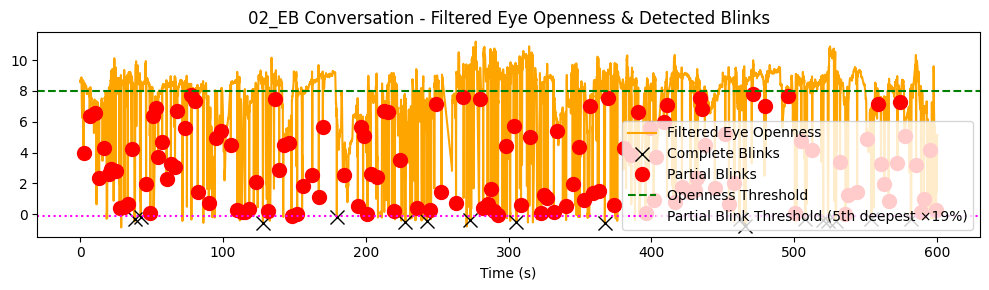

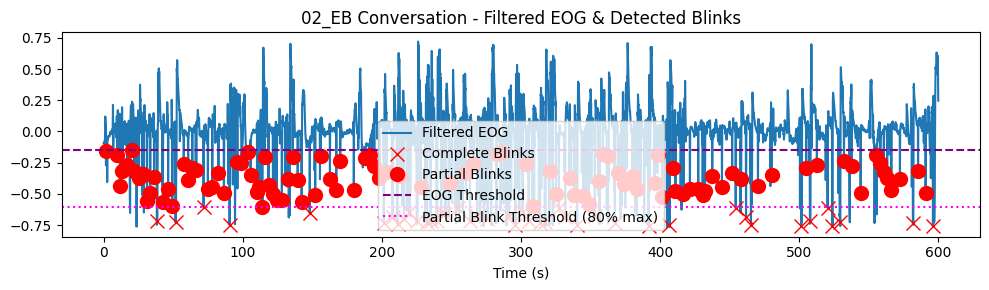

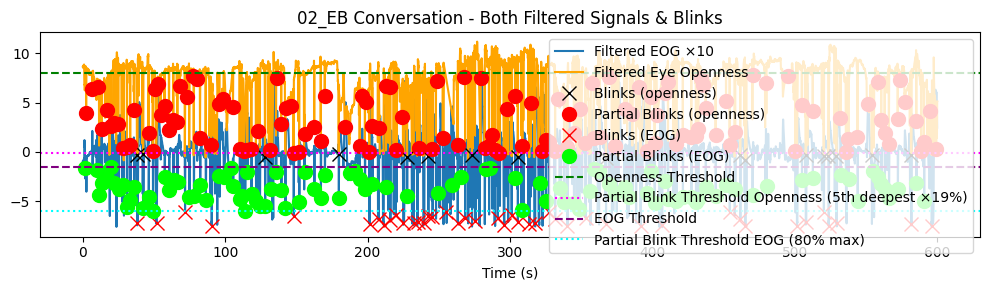

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.701 | PBR (Tobii): 0.885

Processing 03_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


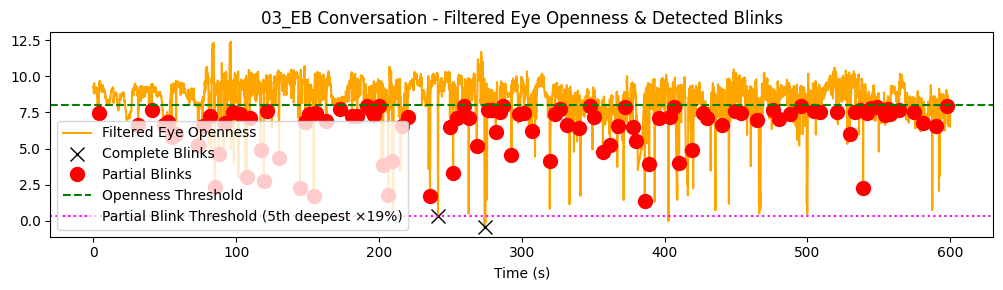

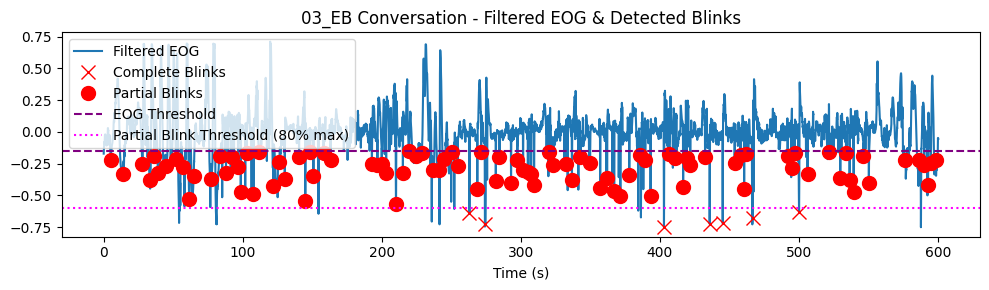

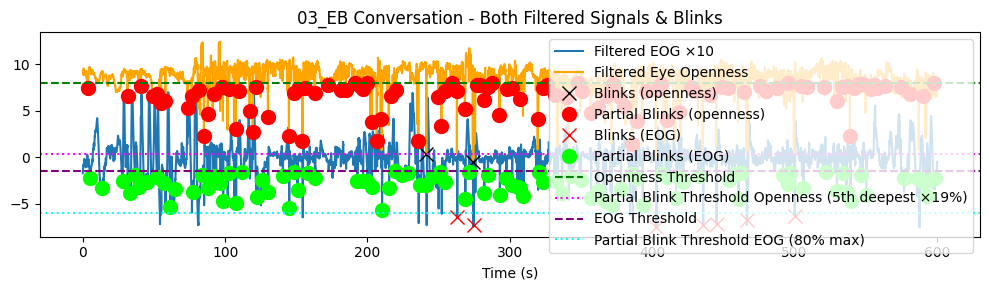

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.931 | PBR (Tobii): 0.981

Processing 04_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


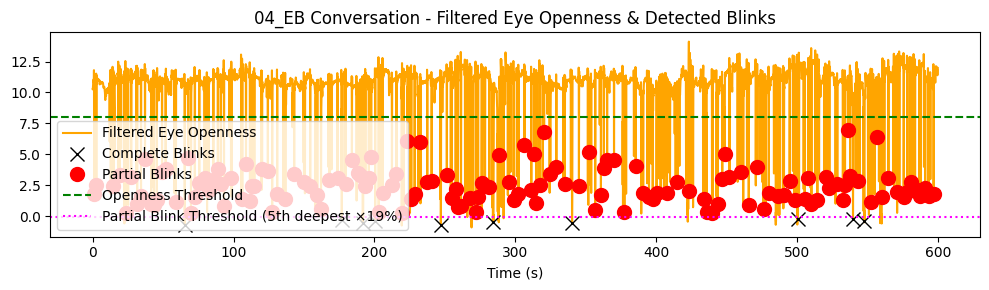

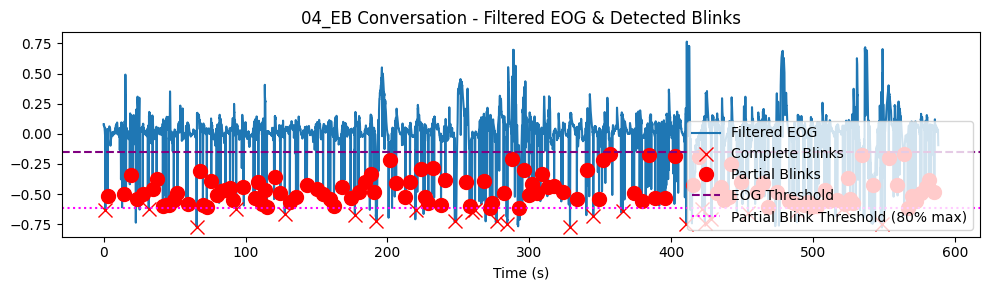

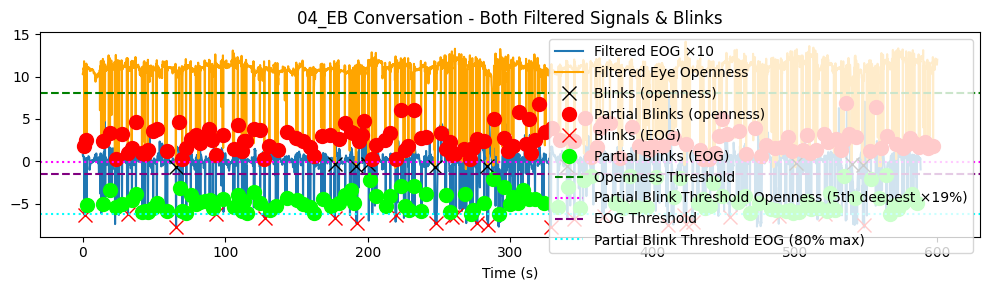

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.831 | PBR (Tobii): 0.934

Processing 05_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


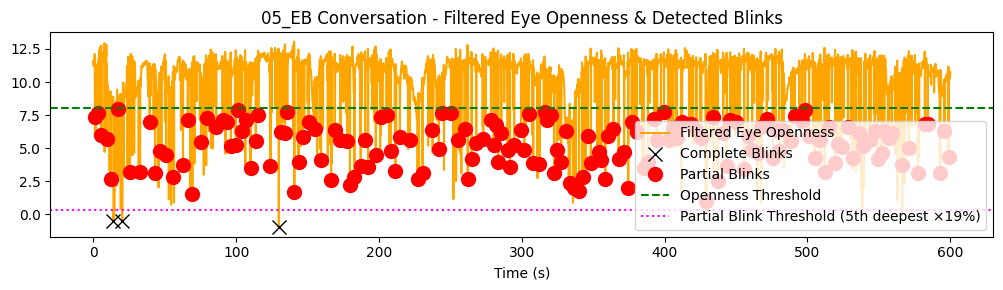

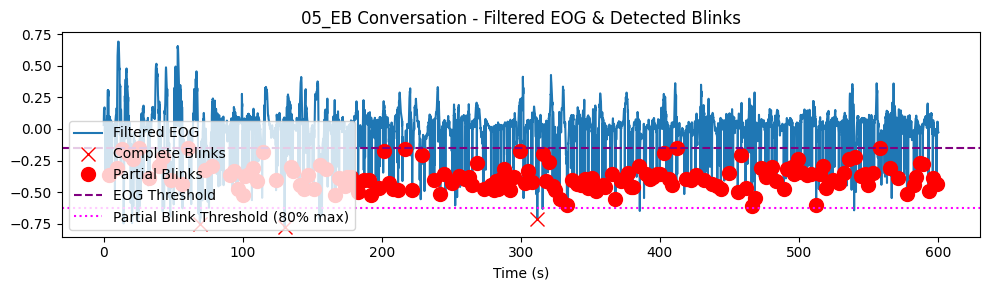

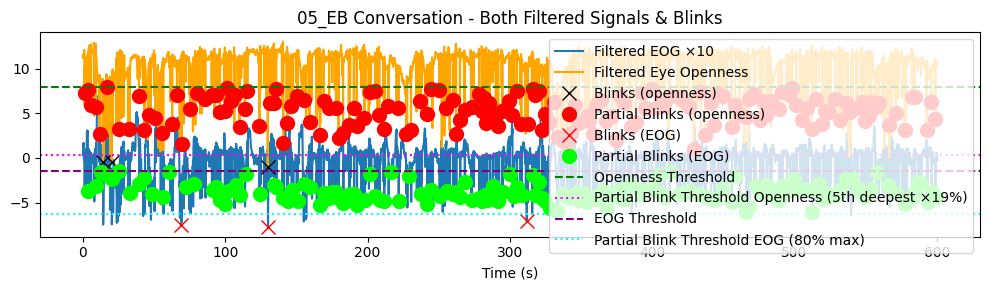

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.981 | PBR (Tobii): 0.982

Processing 06_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


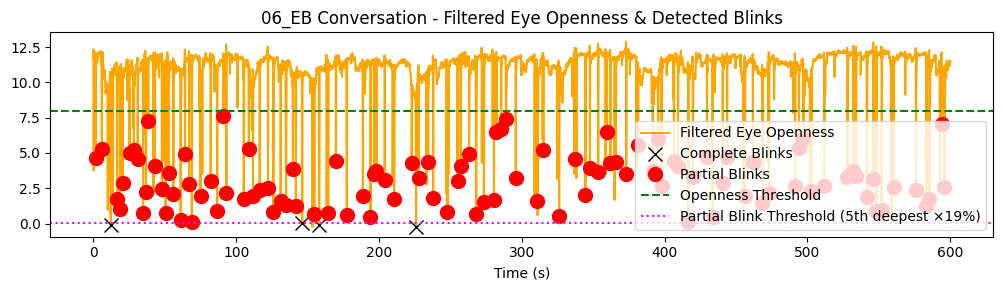

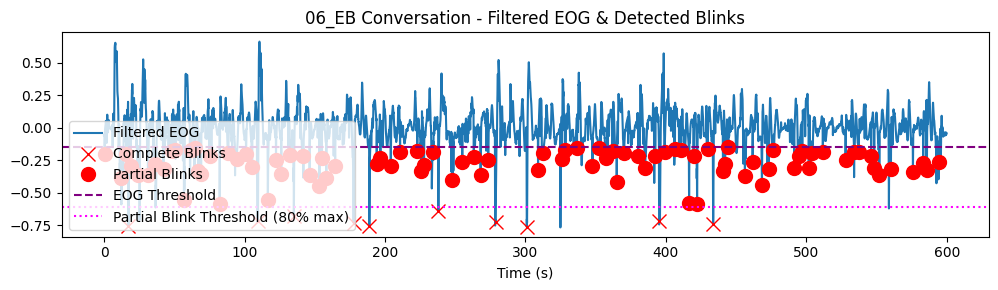

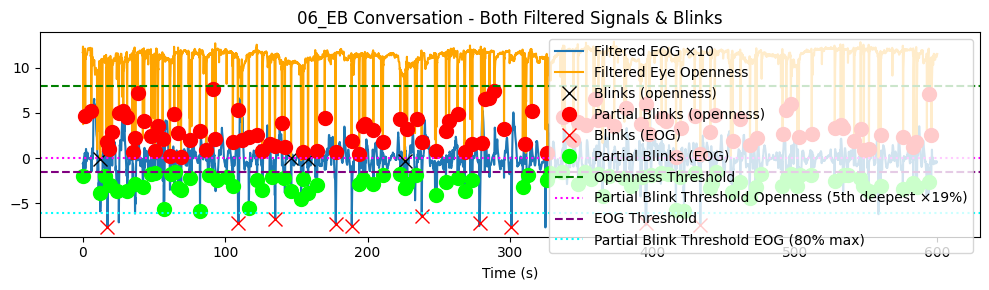

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.900 | PBR (Tobii): 0.963

Processing 07_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


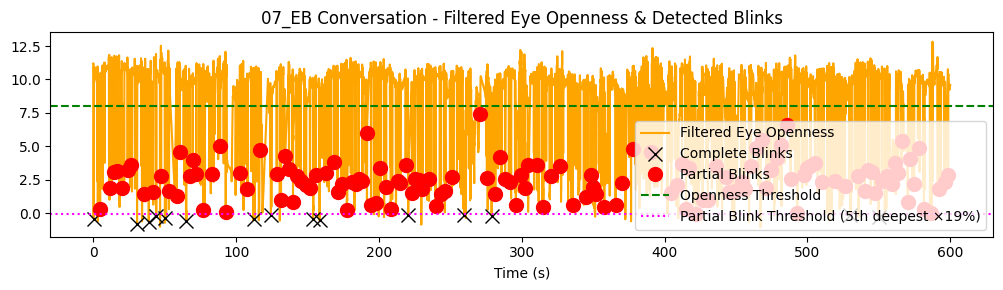

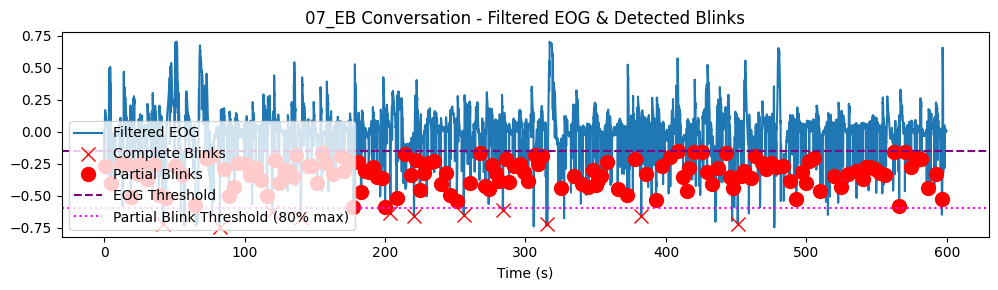

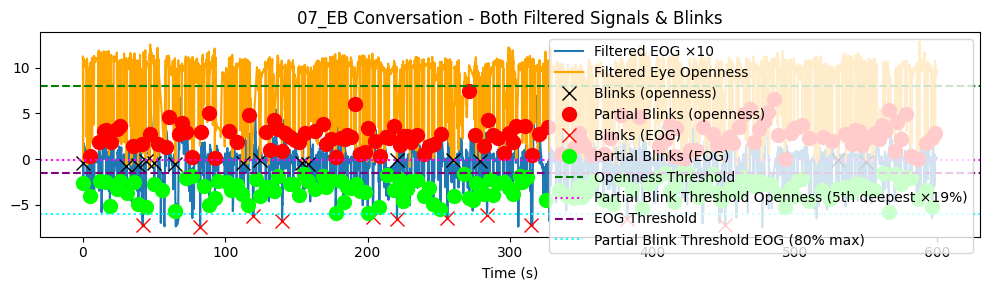

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.927 | PBR (Tobii): 0.900

Processing 08_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


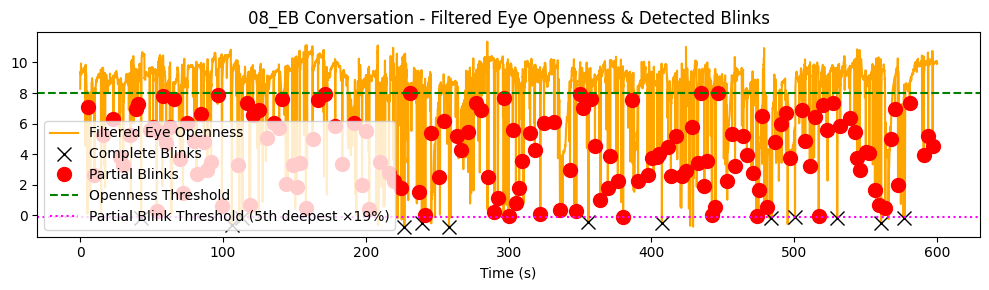

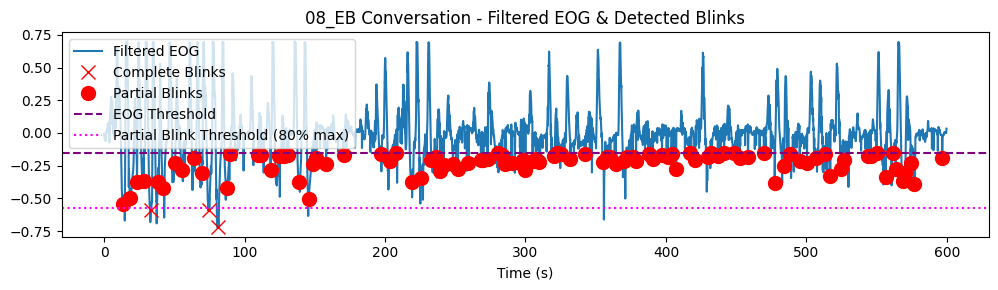

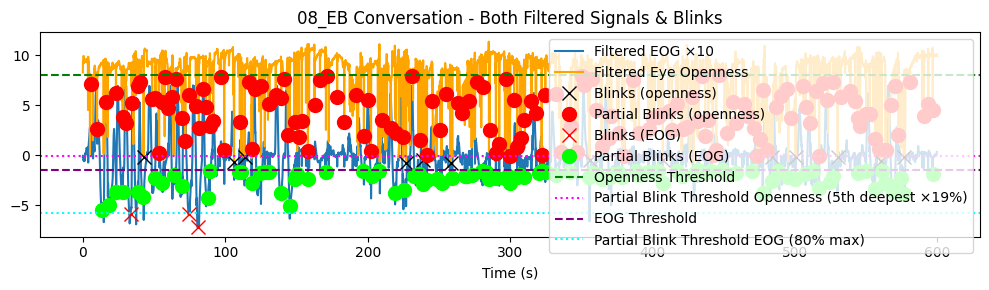

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.971 | PBR (Tobii): 0.920

Processing 09_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


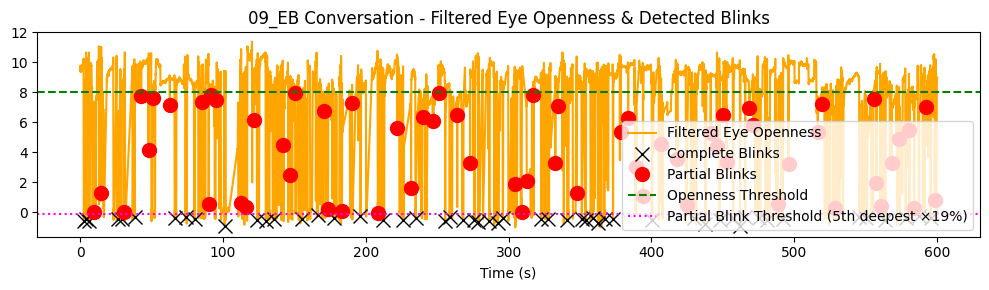

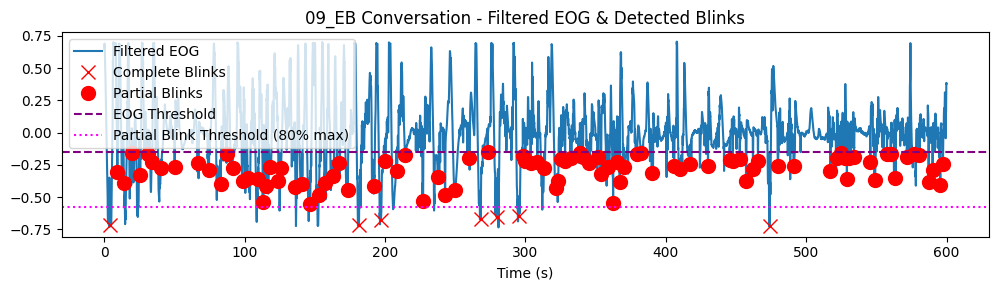

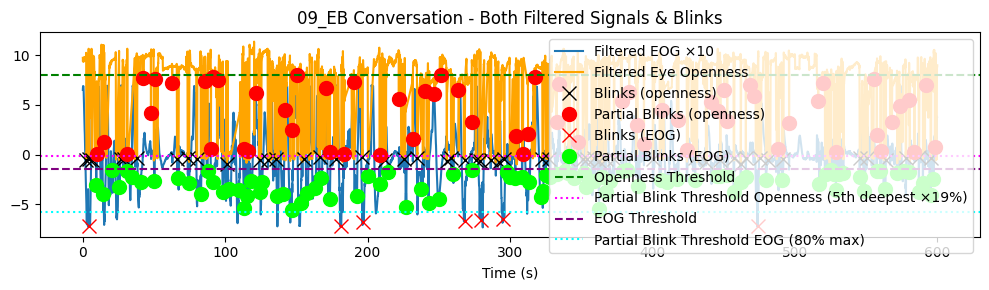

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.930 | PBR (Tobii): 0.543

Processing 10_EB - Conversation


c:\Users\yuz\Documents\Test_LOOK\BlinkDetector-main\BlinkDetector-main\blink.py:445: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.openness_at_peak[df.openness_at_peak < 0] = 0


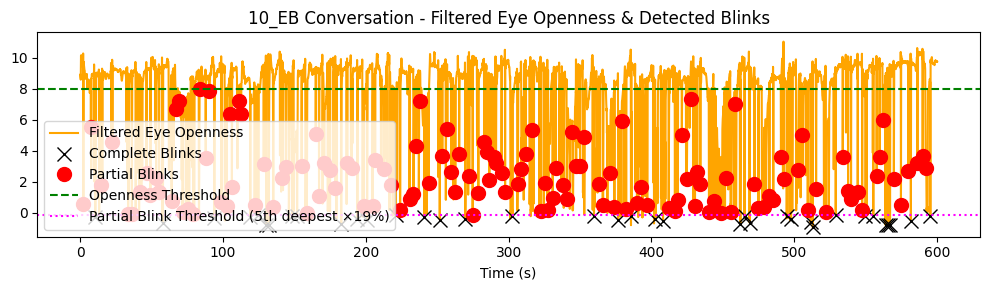

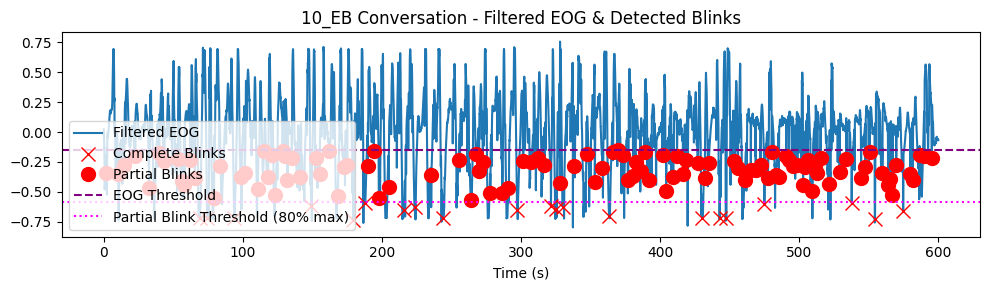

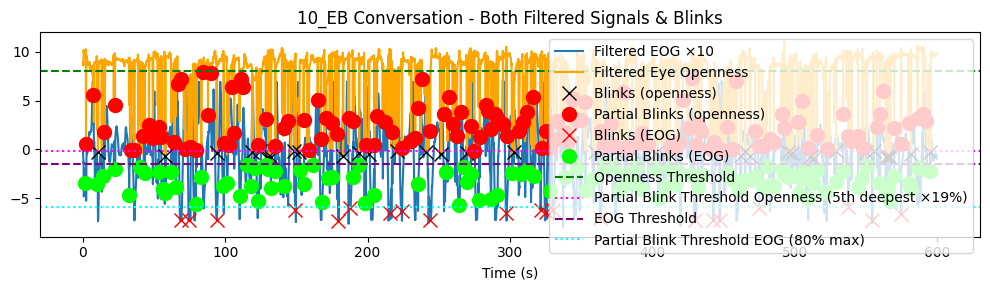

Summary saved to: C:\Users\yuz\Documents\Test_LOOK\partial_blink_rate_analysis.xlsx
PBR (EOG): 0.838 | PBR (Tobii): 0.780


In [6]:
# Assumes analyze_blinks_and_save is already defined in the same script or imported

base_lsl = "C:/Users/yuz/Documents/Test_LOOK/data_lsl/data_exacted"
base_tobii = "C:/Users/yuz/Documents/Test_LOOK/data_Tobii/data_exacted"
excel_out_path = "C:/Users/yuz/Documents/Test_LOOK/partial_blink_rate_analysis.xlsx"
task = "Conversation"
openness_thresh = 8   # Or your value
partial_percentage = 0.8
eye = 'right'

for i in range(1, 11):
    participant = f"{i:02d}_EB"  # 01_EB, 02_EB, ..., 10_EB
    print(f"\nProcessing {participant} - {task}")
    try:
        pbrs = analyze_blinks_and_save(
            base_lsl=base_lsl,
            base_tobii=base_tobii,
            excel_out_path=excel_out_path,
            participant=participant,
            task=task,
            openness_thresh=openness_thresh,
            partial_percentage=partial_percentage,
            eye=eye
        )
        print(f"PBR (EOG): {pbrs['Partial Blink Rate (EOG)']:.3f} | PBR (Tobii): {pbrs['Partial Blink Rate (Tobii)']:.3f}")
    except Exception as e:
        print(f"Failed for {participant}: {e}")
